# Computer Vision, Assignment 4: Model Fitting and Local Optimization

In this assignment, you will how to robustly estimate camera parameters and how to jointly optimize the scene geometry. 
You will mainly use RANSAC and Bundle Adjustment.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


### Reusing functions from prior assignment:
In this assignment, you will build on your prior work. Many of the exercises require you to use functions implemented in assignment 3. To do so most easily, we recommend that you paste those functions into `helpers.py` and import them here by e.g. `from helpers import estimate_F_DLT`. 

In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Note: These functions are provided for your convenience, use them where needed
from supplied import pflat, plot_camera, rital
from helpers import *

# Estimate Essential Matrix using RANSAC

#### *Theoretical exercises 1-2* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/round_church1.jpg" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/round_church2.jpg" width="250px">
    <img alt="right" src="data/round_church_recon.png" width="250px">
    <figcaption>Figure 1: Two images of a church and an example of the obtained 3D reconstruction.</figcaption>
</figure>

The goal of this exercise is to robustly estimate essential matrix $E$ from point matches between the two images. For this, we will use RANSAC with an eight point solver.

The data provided contains calibration matrix $K$, which is the same for both images, and a cell $\mathbf{x}$ with matched image points for the two images. Note that $\mathbf{x}$ are noisy and contain some fraction of outliers.

In [2]:
# First we supply some preliminaries, just loading images and data
img1 = plt.imread('./data/round_church1.jpg')
img2 = plt.imread('./data/round_church2.jpg')

data = sp.io.loadmat('./data/compEx1data.mat')
K = data["K"]
x = [x.astype(np.float32) for x in data['x'][0]]

### Task 1.1

First, compute the essential matrix $E$ with an eight point algorithm using all the point correspondences. Remember to normalize image points using $K$ beforehand. Then convert it to a fundamental matrix $F$. Recall that in Assignment 3, you created functions `estimate_F_DLT(x1s, x2s)`, `enforce_essential(E_approx)`, and `convert_E_to_F(E,K1,K2)`.

In [3]:
# Optional imports
from helpers import estimate_F_DLT, enforce_essential, convert_E_to_F, enforce_fundamental

In [4]:
# ------ Your code here ------
K_inv = np.linalg.inv(K)
x1, x2 = x

#rand_idx = np.random.choice(len(x1[0,:]),8,replace=False)
#x1_8pa = x1[:,rand_idx]
#x2_8pa = x2[:,rand_idx]

# Normalize the image points 
#x1_normK_8pa = K_inv @ x1_8pa
#x2_normK_8pa = K_inv @ x2_8pa

x1_normK_8pa = K_inv @ x1
x2_normK_8pa = K_inv @ x2

# Insert code where you compute the essential matrix
E_approx, sigma_min, residual = estimate_F_DLT(x1_normK_8pa, x2_normK_8pa)
E = enforce_essential(E_approx)

# Insert code where you transform the essential matrix to a fundamental matrix
F_from_E = convert_E_to_F(E,K,K)
F = enforce_fundamental(F_from_E)

print(E)
print(F)

[[-2.57965096e-02 -9.99612506e-01  9.89107707e-03]
 [ 9.98372444e-01 -2.52566374e-02  5.11296102e-02]
 [ 4.84385425e-04 -3.41098887e-03  6.29039845e-05]]
[[-4.50121763e-09 -1.74118760e-07  1.17721271e-04]
 [ 1.73902758e-07 -4.39171588e-09 -1.38063952e-04]
 [-1.04857823e-04  1.63682029e-04 -2.22525984e-02]]


### Task 1.2 

Compute the epipolar lines $\mathbf{l}_2 = F\mathbf{x}_1$ and $\mathbf{l}_1 = F^T\mathbf{x}_2$. Compute the RMS distance between the image points ($\mathbf{x}_1$ and $\mathbf{x}_2$) and corresponding epipolar lines ($\mathbf{l}_1$ and $\mathbf{l}_2$, respectively). 

\begin{align}
& e_{RMS} = \sqrt{\frac{1}{2m}
\left(
\sum_{i=1}^{m} d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + 
\sum_{i=1}^{m} d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)
\right)
},\nonumber \\
& \text{where }~d(\mathbf{x}, \mathbf{l}) = \frac{|l_{1}x_{1}+l_{2}x_{2}+l_{3}|}{\sqrt{l_{1}^2+l_{2}^2}}.
\end{align}

In Assignment 3, you implemented the distances $d(\mathbf{x}, \mathbf{l})$ from image points to the corresponding epipolar lines for the second image in the function `compute_epipolar_errors(F, x1s, x2s)`.


**HINT:** If you transpose the fundamental matrix and change the order of the correpondences, i.e. run `compute_epipolar_errors(F.T, x2s, x1s)` you can obtain the errors to the epipolar lines in the first image.

In [5]:
# Optional imports
from helpers import compute_epipolar_errors 

In [6]:
# ------ Your code here ------

# Compute the epipolar lines, l1 and l2 
l2 = F@x1
l1 = F.T@x2

# Compute RMS distance
e1 = compute_epipolar_errors(F.T, x2, x1)**2
e2 = compute_epipolar_errors(F, x1, x2)**2
m = x1.shape[1]

e_RMS = np.sqrt((np.sum(e1) + np.sum(e2)) / (2 * m))

print("RMS Epipolar Error:", e_RMS)


RMS Epipolar Error: 155.9583221370502


### Task 1.3

Plot two separate histograms with 100 bins for the epipolar errors $\{d({\mathbf{x}_1}_i,{\mathbf{l}_1}_i)\}$ in the first image and $\{d({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\}$ in the second image, respectively. See for example your solution to Assignment 3 Computer Exercise 2.2 for some code on plotting histograms.

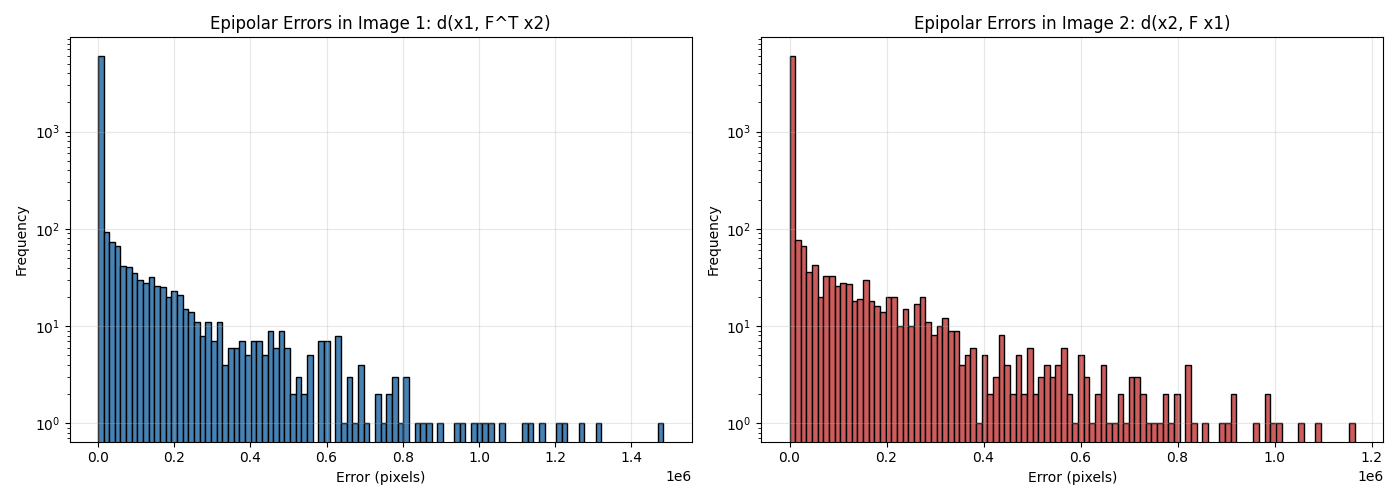

In [7]:
# ------ Your code here ------
plt.figure(figsize=(14, 5))

# Histogram for epipolar errors in image 1
plt.subplot(1, 2, 1)
plt.hist(e1, bins=100, color='steelblue', edgecolor='black')
plt.title("Epipolar Errors in Image 1: d(x1, F^T x2)")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.grid(alpha=0.3)

# Histogram for epipolar errors in image 2
plt.subplot(1, 2, 2)
plt.hist(e2, bins=100, color='indianred', edgecolor='black')
plt.title("Epipolar Errors in Image 2: d(x2, F x1)")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Task 1.4

Pick 20 points in the first image at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same image using the function `rital`. Repeat the plot for the second image.

Q: **Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?** 

A: The plots look partly reasonable, the epipolar lines intersect at a common epipole as expected, however many points lie far from their corresponding epipolar lines, they should be close. The poor alignment indicate an inaccurate fundamental/essential matrix estimate, likely caused by noisy or incorrect matches

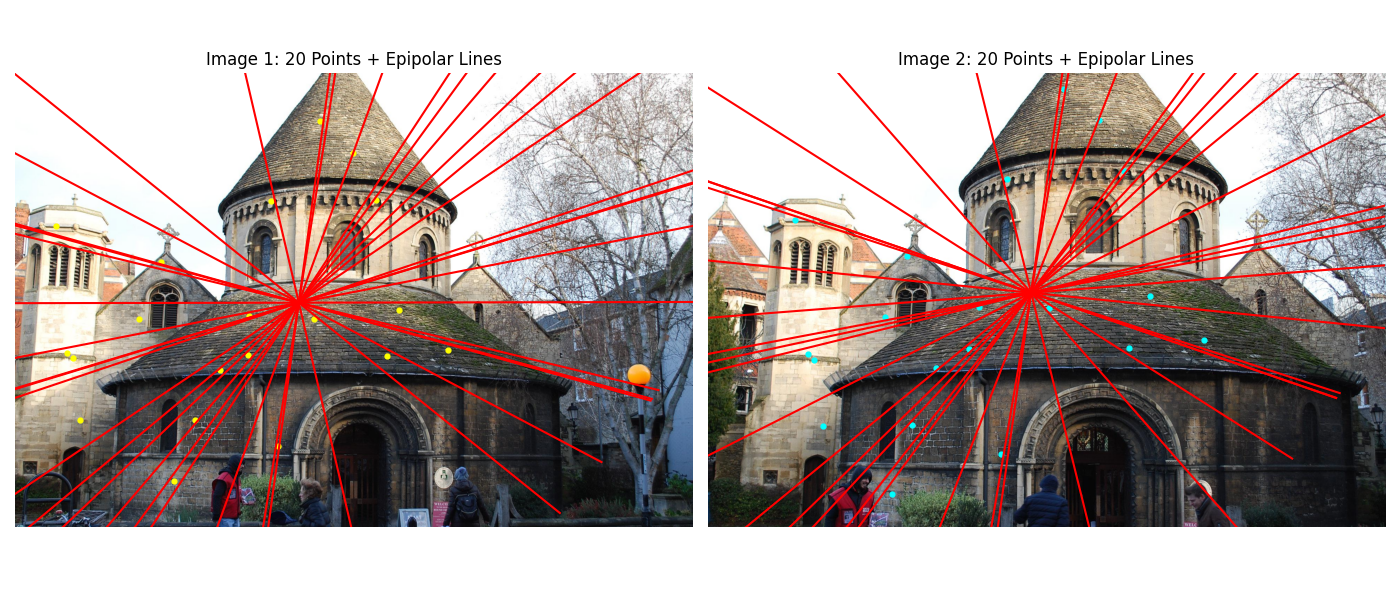

In [8]:
# ------ Your code here ------
from helpers import plot_points_2D
idx20 = np.random.choice(x1.shape[1], 20, replace=False)

x1_20 = x1[:, idx20]
x2_20 = x2[:, idx20]

# Compute corresponding epipolar lines
l2_20 = F @ x1_20      
l1_20 = F.T @ x2_20    

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img1)
ax1.set_title("Image 1: 20 Points + Epipolar Lines")
plot_points_2D(x1_20, ax=ax1, color='yellow', size=12)  
rital(l1_20.T) 
ax1.axis('off')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img2)
ax2.set_title("Image 2: 20 Points + Epipolar Lines")
plot_points_2D(x2_20, ax=ax2, color='cyan', size=12)  
rital(l2_20.T)  
ax2.axis('off')


plt.tight_layout()
plt.show()

### Task 1.5

Next, use RANSAC to robustly compute $E$. Create a function `estimate_E_robust(x1, x2, eps)` that does it, where `eps` is the inlier threshold. Remember again to normalize `x1` and `x2` using $K$ beforehand. Note that for this problem of estimating $E$, a point correspondence $({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$ is a single measurement. Use the same eight point solver as above.

Note that this time only a subset of correspondences will be used by this solver (since in the RANSAC loop, you first randomly sample a subset of correspondences and then compute candidate $E$ from this subset).

Finally, to make RANSAC work, you need to implement an error function that measures how far a single measurement ($({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$) is to the candidate model ($E$). Use the following error function: $\frac12 \left ( d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\right )$, where the epipolar lines ${\mathbf{l}_j}_i$ are computed as before but using $E$ (and therefore are normalized). This error should be familiar to you based on the previous exercises, reuse your implementation from there!

A suggested inlier threshold is 2px (which should also be normalized, see function description below). 

Q: **How many inliers did you get for the returned solution of $E$?**

A: 5816

In [9]:
def estimate_E_robust(x1, x2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire 
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire 
    eps: Normalized inlier threshold - float

    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    # TIPS: 
    # * You can use the already created functions, enforce_essential, estimate_F_DLT, and compute_epipolar_errors
    # * Normalizing the pixel threshold can be done by e.g. eps = threshold_px / K[0,0]
    # * To create an estimate for E using DLT for a random subset of calibrated correspondences...
    # ...you can chain your functions like: E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))

    # * Pseudo code for computing inliers:
    # e1 = compute_epipolar_errors(E, x1, x2)**2 
    # e2 = compute_epipolar_errors(E.T, x2, x1)**2
    # inliers = (1/2)*(e1+e2) < eps**2
    
    # ------ Your code here ------

    if seed is not None:
        np.random.seed(seed)

    N = x1_norm.shape[1]
    best_E = None
    best_inliers = None
    best_num_inliers = -1

    max_iters   = 10000
    sample_size = 8  # 8-point algo

    for it in range(max_iters):
        # 1) random 8-point subset
        idx = np.random.choice(N, sample_size, replace=False)
        x1_s = x1_norm[:, idx]
        x2_s = x2_norm[:, idx]

        # 2) candidate E (DLT + essential enforcement)
        E_hat, _, _ = estimate_F_DLT(x1_s, x2_s)
        E_hat = enforce_essential(E_hat)

        # 3) symmetric epipolar error in *normalized* coords
        d2 = compute_epipolar_errors(E_hat,    x1_norm, x2_norm)**2
        d1 = compute_epipolar_errors(E_hat.T,  x2_norm, x1_norm)**2
        errs = 0.5 * (d1 + d2)

        # 4) inliers
        inliers = errs < eps**2
        num_inliers = np.sum(inliers)

        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_E = E_hat
            best_inliers = inliers.copy()

    # 5) refine E using all inliers of best model
    inlier_idx = np.where(best_inliers)[0]
    E_refined, _, _ = estimate_F_DLT(x1_norm[:, inlier_idx],
                                     x2_norm[:, inlier_idx])
    E_refined = enforce_essential(E_refined)

    # 6) final normalized errors (for curiosity)
    d2_final = compute_epipolar_errors(E_refined,   x1_norm, x2_norm)**2
    d1_final = compute_epipolar_errors(E_refined.T, x2_norm, x1_norm)**2
    final_errs = 0.5 * (d1_final + d2_final)

    return E_refined, best_inliers, final_errs, it

### Task 1.6

Again, compute the RMS distance between the image points and corresponding estimated epipolar lines in both images. Also plot a histogram of epipolar errors for both images as before. 

Q: **Which is the better estimate of the essential matrix, and why?** Repeat plotting 20 random points with the corresponding epipolar lines, but this time pick random points from the subset of correspondences that are ***inliers***.

A: The ransac estimate of the essential matrix is clearly the better one. When plotting epipolar lines the points lie much closer to their corresponding epipolar lines. This is also supported quantitatively by the low RMS epipolar error and the tightly concentrated error histograms, where most errors are well below one pixel.

Using the ransac method we improve the estimate by rejecting incorrect matches and fitting the essential matrix using only geometrically consistent correspondences.

In [10]:
# ------ Your code here ------

# Normalize threshold
m = x1.shape[1]
eps = 2 / K[0, 0]

# Normalize all points
x1_norm = K_inv @ x1
x2_norm = K_inv @ x2

# Run RANSAC
E_ransac, inliers, errs, iters = estimate_E_robust(x1_norm, x2_norm, eps)
E_ransac = enforce_essential(E_ransac)

x1_inliers = x1[:, inliers]
x2_inliers = x2[:, inliers]

F_ransac = convert_E_to_F(E_ransac, K, K)
F_ransac = enforce_fundamental(F_ransac)

e1_ransac = compute_epipolar_errors(F_ransac.T, x2_inliers, x1_inliers)**2
e2_ransac = compute_epipolar_errors(F_ransac, x1_inliers, x2_inliers)**2

e_RMS_ransac = np.sqrt((np.sum(e1_ransac) + np.sum(e2_ransac)) / (2 * m))

print("RANSAC RMS Epipolar Error:", e_RMS_ransac)
print("Number of Inliers:", np.sum(inliers))

RANSAC RMS Epipolar Error: 0.418402223503927
Number of Inliers: 5812


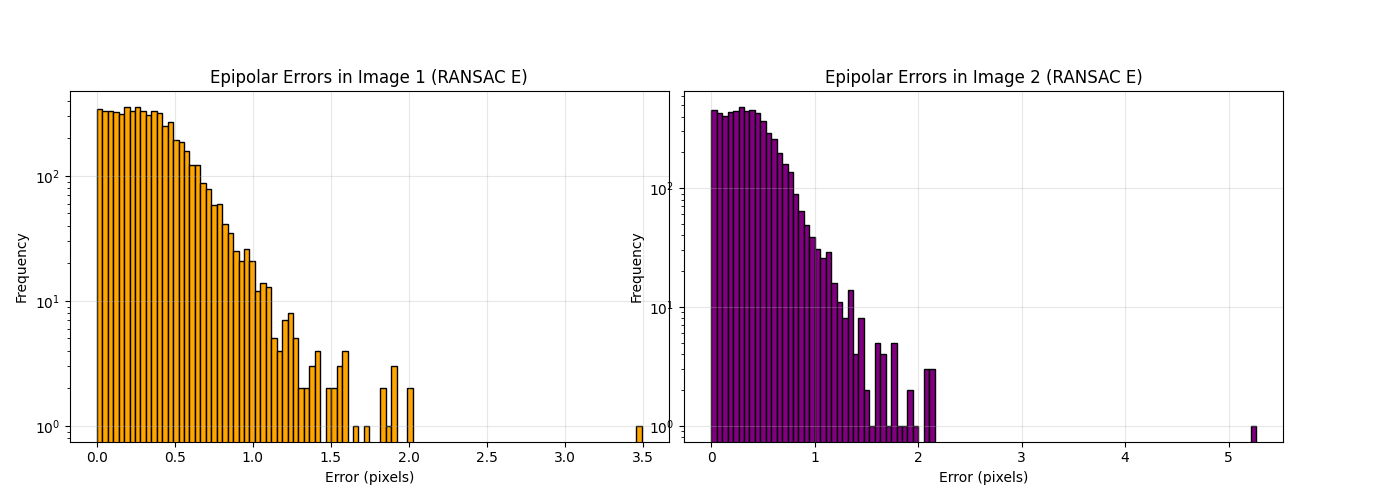

In [11]:
plt.figure(figsize=(14, 5))

# Image 1 errors
plt.subplot(1, 2, 1)
plt.hist(np.sqrt(e1_ransac), bins=100, color='orange', edgecolor='black')
plt.title("Epipolar Errors in Image 1 (RANSAC E)")
plt.xlabel("Error (pixels)")
plt.yscale('log')
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

# Image 2 errors
plt.subplot(1, 2, 2)
plt.hist(np.sqrt(e2_ransac), bins=100, color='purple', edgecolor='black')
plt.title("Epipolar Errors in Image 2 (RANSAC E)")
plt.xlabel("Error (pixels)")
plt.yscale('log')
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



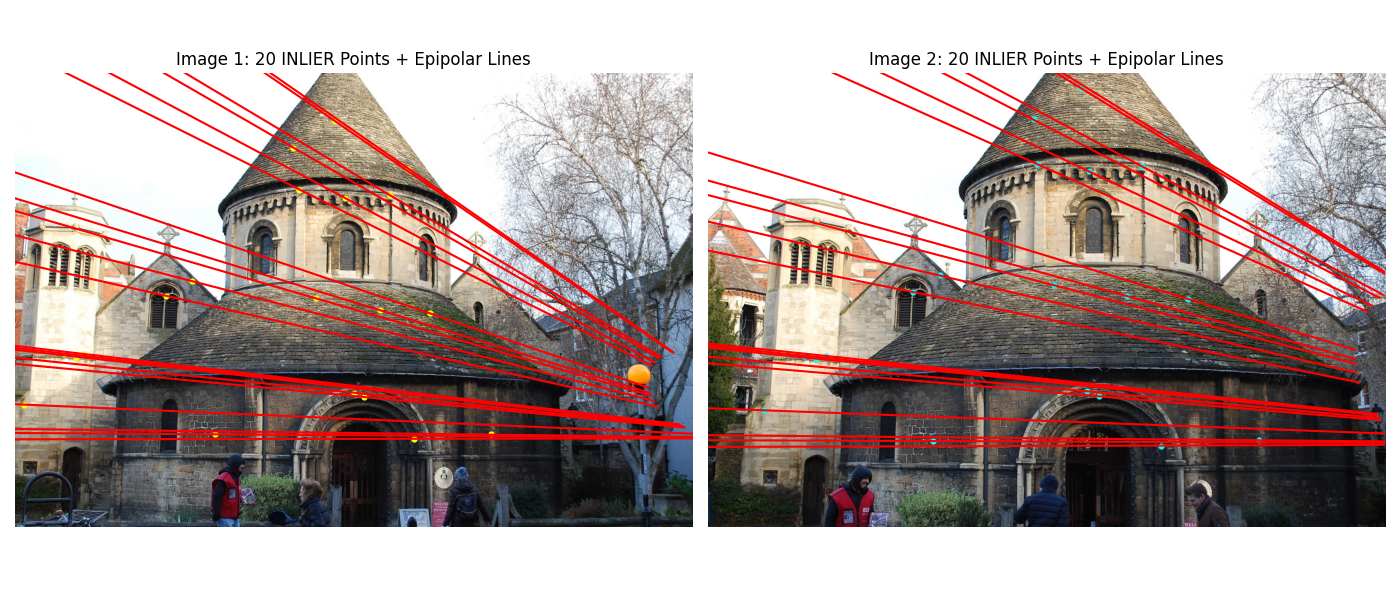

In [12]:
# Select 20 random inliers
inlier_indices = np.where(inliers)[0]
idx20 = np.random.choice(inlier_indices, 20, replace=False)

x1_in20 = x1[:, idx20]
x2_in20 = x2[:, idx20]

# Compute lines
l2_in20 = F_ransac @ x1[:, idx20]
l1_in20 = F_ransac.T @ x2[:, idx20]

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img1)
ax1.set_title("Image 1: 20 INLIER Points + Epipolar Lines")
plot_points_2D(x1_in20, ax=ax1, color='yellow', size=12)
rital(l1_in20.T)
ax1.axis('off')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img2)
ax2.set_title("Image 2: 20 INLIER Points + Epipolar Lines")
plot_points_2D(x2_in20, ax=ax2, color='cyan', size=12)
rital(l2_in20.T)
ax2.axis('off')

plt.tight_layout()
plt.show()


## Computer Exercise 2
<figure align="center">
    <img alt="left" src="data/fountain1.png" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/fountain2.png" width="250px">
    <img alt="right" src="data/fountain_recon.png" width="250px">
    <figcaption>Figure 2: Two images of a fountain and an example of the obtained 3D reconstruction.</figcaption>
</figure>

In this exercise you will build a 2-view reconstruction pipeline that connects feature extraction,
matching, robust essential matrix estimation from the previous computer exercise, and triangulation.

You can use the two supplied images from the data and the intrinsics provided. We load the required data for your convenience below:

In [13]:
data = sp.io.loadmat('./data/compEx2data.mat')
K = data['K']
img1 = (plt.imread('./data/fountain1.png') * 255).astype('uint8')
img2 = (plt.imread('./data/fountain2.png') * 255).astype('uint8')

### Task 2.1

We will begin by computing SIFT features and matching them. Since OpenCV has quite a difficult API for this we have supplied some code snippets. And you already learned much of the basics of this from Assignment 2, so we provide some basic code to get you started.

The implementation is based on their official guide for image matching (https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) and uses Lowe's ratio test to filter out matches that are too similar, this should be similar to what you have done in previous assignments.

In [14]:
# Some supplied code on how to compute matches using OpenCV

from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
# Apply ratio test
# Here we filter out matches that are too similar to other matches (because then they are likely wrong)
# This is standard in OpenCV, see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        matches.append([m])

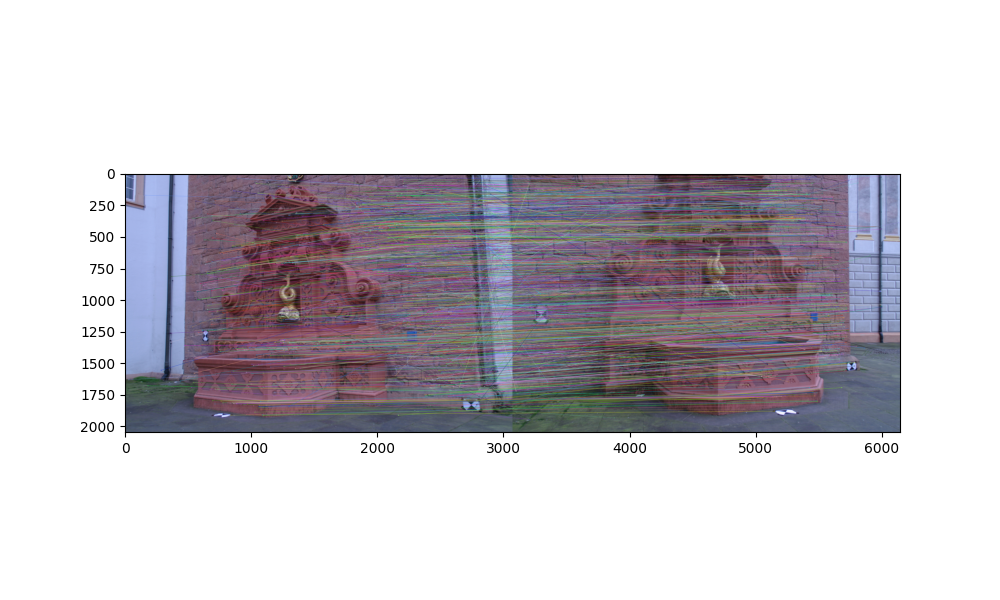

(<matplotlib.image.AxesImage at 0x28aa15bad70>, None)

In [15]:
# Run this code for a simple plot of the filtered matches

# Just making sure no other figures are impacting this one
#plt.close()
#plt.clf()   
#plt.cla() 
# Here is some supplied code from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Feel free to play around with it
plt.figure(figsize=(10,6))
img3 = drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

### 

Q: **Run the code above. Do the matches look reasonable?**

A: There are point that match but also obvious missmatces, but without filtering, this is a reasonable result

Q: **How many SIFT features did you find for the two images, respectively? How many total matches did you find? How many good matches did you find after the ratio test?**

A: 
Number of SIFT features in image 1: 19410

Number of SIFT features in image 2: 17618

Total matches found (before ratio test): 19410

Good matches (after ratio test): 1049


In [16]:
# ------ Your code here ------

# Count SIFT features per image
num_kp1 = len(kp1)
num_kp2 = len(kp2)

# Count number of total matches
num_all_matches = len(all_matches)

# Count the number of good matches after the ratio-test
num_good_matches = len(matches)

print("Number of SIFT features in image 1:", num_kp1)
print("Number of SIFT features in image 2:", num_kp2)
print("Total matches found (before ratio test):", num_all_matches)
print("Good matches (after ratio test):", num_good_matches)

Number of SIFT features in image 1: 19410
Number of SIFT features in image 2: 17618
Total matches found (before ratio test): 19410
Good matches (after ratio test): 1049


Now we supply a little more code just to make it easier. We extract the keypoints corresponding to the good matches and save them as x1 and x2. We do this because currently the type of kp1 etc... are OpenCV specific

In [17]:
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
x = np.array([x1, x2])

### Task 2.2

Now you should find the essential matrix describing the transformation between the two images.
Because not all matches are correct, you need to use RANSAC to find a set of good correspondences (inliers). 
To estimate the essential matrix use the function `estimate_E_robust(x1,x2,eps)` that you created in the previous computer exercise.

Q: **How many inliers did you find?**

A: Varies, but often between 300-700


In [18]:
# ------ Your code here ------
K_inv = np.linalg.inv(K)

x1_norm = K_inv @ x1
x2_norm = K_inv @ x2
eps = 2.0 / K[0,0]

# Compute the essential matrix based on the keypoint matches we just computed between the two images
E_robust, inliers, errs, iters = estimate_E_robust(x1_norm, x2_norm, eps)

# Print the number of inliers
print("Number of SIFT matches:", x1.shape[1])
print("Number of inliers:", np.sum(inliers))


Number of SIFT matches: 1049
Number of inliers: 742


### Task 2.3

After getting the robust essential matrix estimation, you should find the camera matrix of the second view. Remember that there are 4 possible solutions (see Theoretical Exercise 7 of HA3)! You should pick the solution that has more points in front of the camera. Remember, in Assigment 3 you implemented `extract_P_from_E(E)`

**Hint:** You need to perform triangulation by using a function from a previous computer exercise. The 3D points X and the 2d correspondences x1 and x2 wil also be needed for the next task in this assignment!

Q: **Which of the solutions seems correct to you?**

A: Depends on which run and what poitns we pick but this time i got sol 2 as correct

In [19]:
# Optional import
from helpers import extract_P_from_E, triangulate_3D_point_DLT

Points in front of both cameras: 0/742
_______________________________________
Points in front of both cameras: 0/742
_______________________________________
Points in front of both cameras: 742/742
_______________________________________
Points in front of both cameras: 0/742
_______________________________________


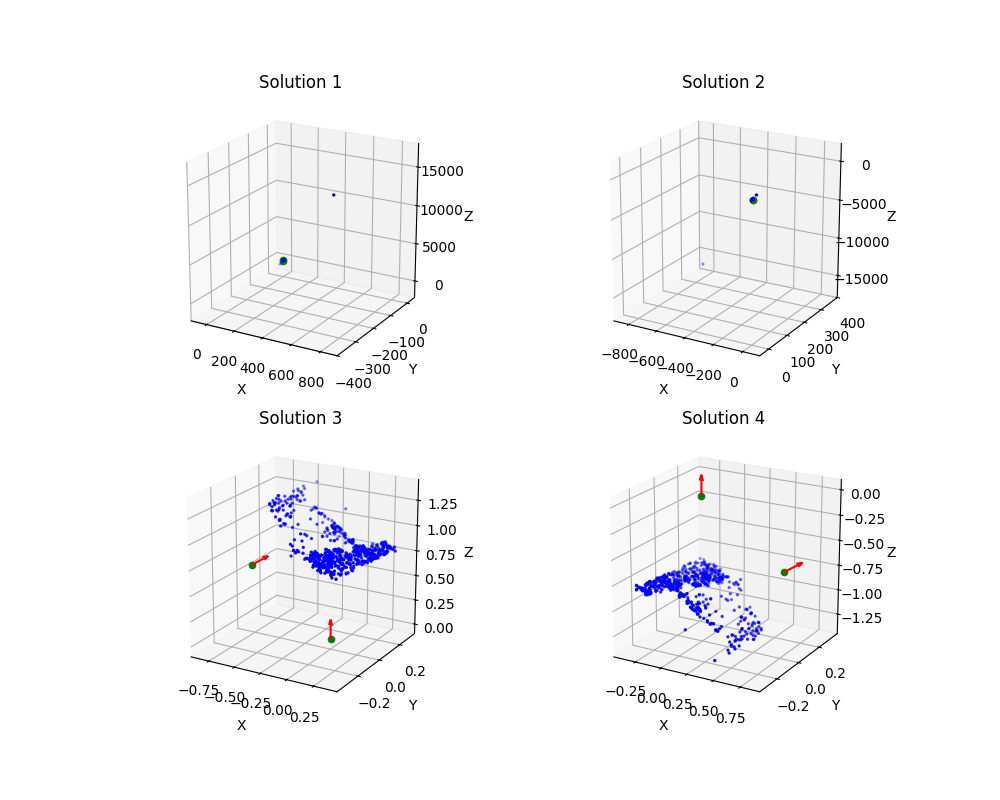


Correct P2 index: 2
Number of points in front: 742


In [20]:
# ------ Your code here ------

# Compute the 4 possible camera matrices
P_candidates = extract_P_from_E(E_robust)
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))

# Inlier correspondences 
x1_in = x1[:, inliers]
x2_in = x2[:, inliers]

fig = plt.figure(figsize=(10, 8))

front_counts = []
for i in range(4):

    # Build P2 
    P2 = K @ P_candidates[i]

    # Triangulate all inliers
    X_list = []
    for j in range(x1_in.shape[1]):
        X_list.append(
            triangulate_3D_point_DLT(x1_in[:, j], x2_in[:, j], P1, P2)
        )
    Xs = np.array(X_list).T 
    X_euclid = Xs[:3, :]

    count = count_points_in_front(P1, P2, Xs)
    front_counts.append(count)

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(f"Solution {i+1}")

    # Plot triangulated 3D points
    plot_points_3D(X_euclid, ax=ax, size=2, kwargs={'color':'blue'})

    # Plot Camera 1
    plot_camera(P1, scale=0.2, ax=ax)

    # Plot Camera 2 for this solution
    plot_camera(P2, scale=0.2, ax=ax)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=20, azim=-60)

    print(f"Points in front of both cameras: {count}/{x1_in.shape[1]}")
    print("_______________________________________")

plt.show()

best_idx = np.argmax(front_counts)
print(f"\nCorrect P2 index: {best_idx}")
print("Number of points in front:", front_counts[best_idx])


### Summary of reconstruction pipeline

In summary, you have performed a 2d-view reconstruction pipeline consisting of the following steps:
1. **Load the two images**, find SIFT features, and match them.

2. **Estimate the essential matrix** robustly using  
   `estimate_E_robust(x1, x2, eps)`.

3. **Compute the four possible camera matrix pairs** for the essential matrix, and for each pair:
   1. Triangulate the 3D points using the camera matrix pair and the matched image points.
   2. Compute the camera centers and principal directions of both cameras.
   3. Plot everything in 3D.

4. **Choose the correct solution** (out of the four) by selecting the one that yields the highest number of 3D points (inliers) lying in front of the cameras.  

The final visualization should resemble the right-most result in the first Figure of Computer Exercise 2 after removing most outliers.

This pipeline will come in handy for the project and somewhat resembles the first stage in any modern SfM pipeline like [COLMAP](https://github.com/colmap/colmap).

#### *Theoretical exercises 3* (see pdf)

## 
Computer Exercise 3

In this exercise you will use the solution from Computer Exercise 2 as a starting point and locally improve it using the Levenberg-Marquardt method. If you have doubts about the correctness of your solution from the earlier exercise, you can instead use the provided data in `compEx3data.mat` as starting solution (you can load it like `data = sp.io.loadmat('./data/compEx3data.mat')` and then use that for your x and camera matrices).

The goal is to refine the solution **3D points (not camera matrices, those you can assume fixed**).
You will loop over the 3D points and update them one by one using Levenberg-Marquardt (LM), please see the lecture notes or [Wikipedia page on Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for more information.

In short, LM is an iterative method for minimizing a non-linear least squares objective
\begin{equation}
   F(v)=\|r(v)\|^2, 
\end{equation}
with respect to $v$.
In LM, the update is given by
\begin{equation}
\delta v =  - (J(v)^TJ(v)+\mu I)^{-1}J(v)^Tr(v),
\end{equation}
where $J(v)$ is the Jacobian of $r(v)$ at $v$.
Here $\mu>0$ is a damping factor that is adjusted adaptively and $v$ is the previous solution.
The new solution is $v+\delta v$ and we iterate until convergence (or for a fixed number of iterations).

We can also define the **reprojection error** to be: $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ (as in Equation (2) in the Theoretical Exercises)

In our setting, we have $v=X_j$ and $r(v)=r(X_j)$. Please see the main PDF for some more details about the definition of $r$ (e.g. Equation (3) for the definition).

You will have to implement three functions in this exercise:

1. `(err,res) = compute_reprojection_error(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the reprojection error ($\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $) given two cameras $P_i$, a 3D point $X_j$ and 2D points $x_{ij}$ in the images corresponding to the cameras $P_i$ and the 3D point $X_j$. It also returns the values of all the individual residuals as a second output, i.e., the residual vector $r(\mathbf{X}_j)$.
    
2. `(r,J) = linearize_reproj_err(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the linearization ($r$ and $J$) as described in Equation (7) in the Theoretical Exercises.
    
3. `delta_X_j = compute_update(r, J, mu)`: a function that computes the LM-update given $r$, $J$ and $\mu$ as described in Equation (9) in the Theoretical Exercises.

The idea is now to use *decoupled* LM, i.e. loop over the 3D points and refine them one by one.

Let's first start by implementing the functions in code!

**NOTE**: Below we have provided suggestion for the function signatures. However, you are free to implement the actual functions however you'd like. For example, you don't have to take the inputs and outputs on the exact form we suggest. This is one way to store the Jacobians, residuals, etc..., feel free to decide how you feel is best.

In [21]:
# Random useful commands:

# Computes the LM update .
# C = J.T @ J + mu * np.eye(J.shape[1])
# c = J.T @ r
# delta = -np.linalg.solve(C, c)

In [22]:
def compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j):
    """
    Compute the reprojection error for a single 3D point.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Projection matrices.

    X_j : ndarray (4,)
        3D homogeneous point.

    x_1j, x_2j : ndarray (2,)
        Observed image positions.

    Returns
    -------
    err : float 
        Reprojection error.

    r : Residual vector. For example, an ndarray of shape (2, 2)
        However, you can decide in your own implementation.
    """
    # ------ Your code here ------
    x1_h = P_1 @ X_j
    x2_h = P_2 @ X_j

    x1_proj = x1_h[:2] / x1_h[2]
    x2_proj = x2_h[:2] / x2_h[2]

    r1 = x_1j - x1_proj
    r2 = x_2j - x2_proj
   
    res = np.vstack([r1, r2])
    
    err = np.linalg.norm(res)**2

    return err, res

In [23]:
def linearize_reproj_err(P_1, P_2, X_j, x_1j, x_2j):
    """
    Linearize the reprojection error for a single 3D point observed in two views.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Camera matrices.

    X_j : ndarray (4,)
        Homogeneous 3D point.

    x_1j, x_2j : ndarray (2,)
        Observed image coordinates for this point in cameras 1 and 2.

    Returns
    -------
    r : Linearization of r. For example an ndarray of shape (4,) representing concatenated reprojection residuals: [r1_x, r1_y, r2_x, r2_y].
        However, you can decide for yourself how you want to store this.

    J : Linearization of J. For example, an ndarray of shape (4, 4) representing a concatenation of the two Jacobians
        However, you can decide for yourself how you want to store this.

    Notes
    -----
    This creates the linear system used in Levenberg-Marquardt.
    """
    # ------ Your code here ------
   
    _, res = compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j)
    r = res.reshape(-1)

    p11, p12, p13 = P_1   # (4,)
    p21, p22, p23 = P_2
    
    z11, z21, z31 = P_1 @ X_j  
    z12, z22, z32 = P_2 @ X_j  

    # Camera 1 Jacobian rows (2x4)
    J11 = (z11 / z31**2) * p13 - (1.0 / z31) * p11   
    J21 = (z21 / z31**2) * p13 - (1.0 / z31) * p12   
    
    # Camera 2 Jacobian rows (2x4)
    J12 = (z12 / z32**2) * p23 - (1.0 / z32) * p21  
    J22 = (z22 / z32**2) * p23 - (1.0 / z32) * p22   
    
    # Stack all rows into a (4,4) Jacobian
    J = np.vstack([J11, J21, J12, J22])

    return r, J

In [24]:
def compute_update(r, J, mu):
    """
    Compute the LM update step for a single 3D point.

    Parameters
    ----------
    r : For example, ndarray of shape (4,)
        Residual vector.

    J : For example, ndarray of shape (4, 4)
        Jacobian of the residuals w.r.t. the 3D point.

    mu : float
        Levenberg–Marquardt damping parameter.

    Returns
    -------
    delta : ndarray of shape (4,)
        Update ΔX to apply to the 3D point.

    Notes
    -----
    Solves:
        (JᵀJ + μI) δ = -Jᵀ r
    """
    # ------ Your code here ------
    C = J.T @ J + mu * np.eye(J.shape[1])
    c = J.T @ r
    delta = -np.linalg.solve(C, c)

    return delta

Median reprojection error before BA: 11.65992133831035
Median reprojection error after BA: 11.19789965906536


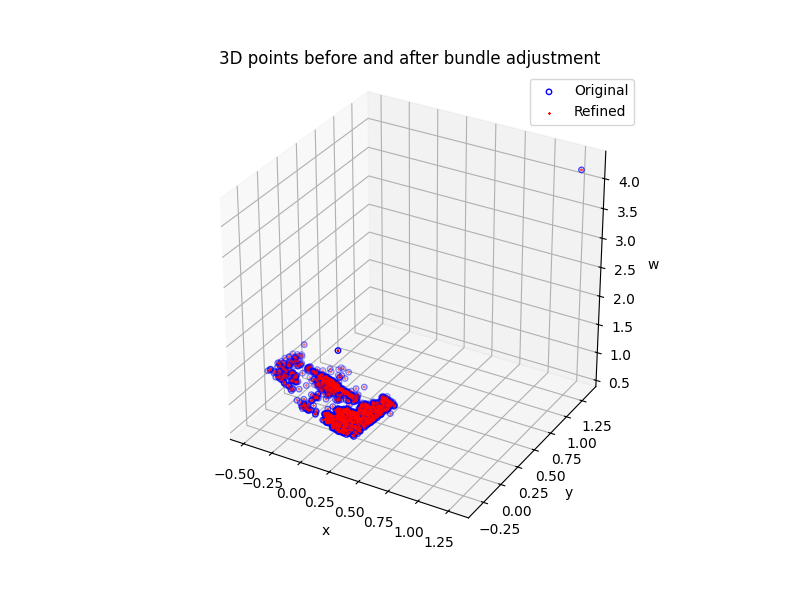

In [25]:
def compute_median_reproj_error(P1, P2, X, x1, x2):
    errs = []
    for j in range(N):
        err, _ = compute_reprojection_error(
            P1, P2,
            X[:, j],
            x1[:2, j],
            x2[:2, j]
        )
        errs.append(err)

    return np.median(errs)

# ------ Your code here ------
data = sp.io.loadmat('./data/compEx3data.mat')
K = data['K']
x_j = data['x'][0,:]
X_j = data['X']
P = data['P'][0,:]

P1, P2 = P
x_1j, x_2j = x_j 
N = X_j.shape[1]

# Print the median reprojection error before bundle adjustment
errs_med_before = compute_median_reproj_error(P1, P2, X_j, x_1j, x_2j)
print("Median reprojection error before BA:", errs_med_before)

# Perform bundle adjustment by looping through your N points
# For each point, compute the Levenberg-Marquadt update
# Use the update to update the 3D point (the camera matrices are fixed!)

mu = 1e-3
n_iters = 5
X_refined = X_j.copy() 

def LM_update(N, P1, P2, X, X_new, x1, x2, n_iters, mu):

    for j in range(N):
    
        Xj = X_new[:, j]
    
        for _ in range(n_iters):
            r, J = linearize_reproj_err(P1, P2, Xj, x1[:2, j], x2[:2, j])
    
            delta = compute_update(r, J, mu)
            
            Xj = Xj + delta
    
        X_new[:, j] = Xj

    return X_new

X_refined = LM_update(N, P1, P2, X_j, X_refined, x_1j, x_2j, n_iters, mu)

# Print the median reprojection error after bundle adjustment
errs_med_after = compute_median_reproj_error(P1, P2, X_refined, x_1j, x_2j)
print("Median reprojection error after BA:", errs_med_after)

# Plot the refined 3D points in the same plot as the originals
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Original points
plot_points_3D(X_j[:3, :], ax=ax, size=15, kwargs={'facecolors': 'none',
                                                  'edgecolors': 'blue',
                                                  'marker': 'o',
                                                  'label': 'Original'
                                                 })

# Refined points
plot_points_3D(X_refined[:3, :], ax=ax, size=1, kwargs={'color': 'red', 
                                                        'marker': 'x',
                                                        'label': 'Refined'})

ax.legend()
ax.set_title("3D points before and after bundle adjustment")
plt.show()

Compare the total reprojection error (sum of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.
Also compare the median reprojection error (median of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.

Finally plot the refined 3D points in the same plot as the originals.

Q: **What do you observe?**

A: After running LM bundle adjustment the total and median error decrease slightly indication points are reprojected more accurately after optimization.

In the 3D plot, the refined points lie very close to the original ones

## **OPTIONAL**: Computer Exercise 4 (10 points)

Perform an empirical noise sensitivity analysis of your LM-solver from the previous exercise.
Add i.i.d. mean-zero Gaussian noise with standard deviation $\sigma_X\in\{0,0.1\mathrm{m}\}$ to the 3D points and $\sigma_x\in\{0,3\mathrm{px}\}$ to the 2D points (from SIFT), yielding (at least) four noise combinations ($\sigma_X$, $\sigma_x$) to try.
See how the total reprojection error and median reprojection error as computed in the previous exercise varies before and after LM with the added noise.
If you want to, you can test other noise types as well.

Q: **Report your findings with plots and numbers in some reasonable manner.**

A: [Insert your answer]

In [26]:
# ------ Your code here ------
def add_noise_3D(X, sigma_X):
    Xn = X.copy()
    Xn[:3, :] += sigma_X * np.random.randn(3, X.shape[1])
    return Xn

def add_noise_2D(x, sigma_x):
    xn = x.copy()
    xn[:2, :] += sigma_x * np.random.randn(2, x.shape[1])
    return xn

def compute_total_reproj_error(P1, P2, X, x1, x2):
    err = 0.0
    for j in range(X.shape[1]):
        e, _ = compute_reprojection_error(
            P1, P2,
            X[:, j],
            x1[:2, j],
            x2[:2, j]
        )
        err += e
    return err

#-----------------------------------------

sigmas_X = [0.0, 0.1]
sigmas_x = [0.0, 3.0]

results = []

for sigma_X in sigmas_X:
    for sigma_x in sigmas_x:

        # add noise to x and X
        X_noisy = add_noise_3D(X_j, sigma_X)
        x1_noisy = add_noise_2D(x_1j, sigma_x)
        x2_noisy = add_noise_2D(x_2j, sigma_x)

        # errs before LM 
        med_before = compute_median_reproj_error(
            P1, P2, X_noisy, x1_noisy, x2_noisy
        )
        tot_before = compute_total_reproj_error(
            P1, P2, X_noisy, x1_noisy, x2_noisy
        )
        
        X_refined = X_noisy.copy()
        
        X_refined = LM_update(N, P1, P2, X_noisy, X_refined, x1_noisy, x2_noisy, n_iters, mu)

        # --- Errors AFTER LM ---
        med_after = compute_median_reproj_error(
            P1, P2, X_refined, x1_noisy, x2_noisy
        )
        tot_after = compute_total_reproj_error(
            P1, P2, X_refined, x1_noisy, x2_noisy
        )

        results.append({
            "sigma_X": sigma_X,
            "sigma_x": sigma_x,
            "median_before": med_before,
            "median_after": med_after,
            "total_before": tot_before,
            "total_after": tot_after
        })


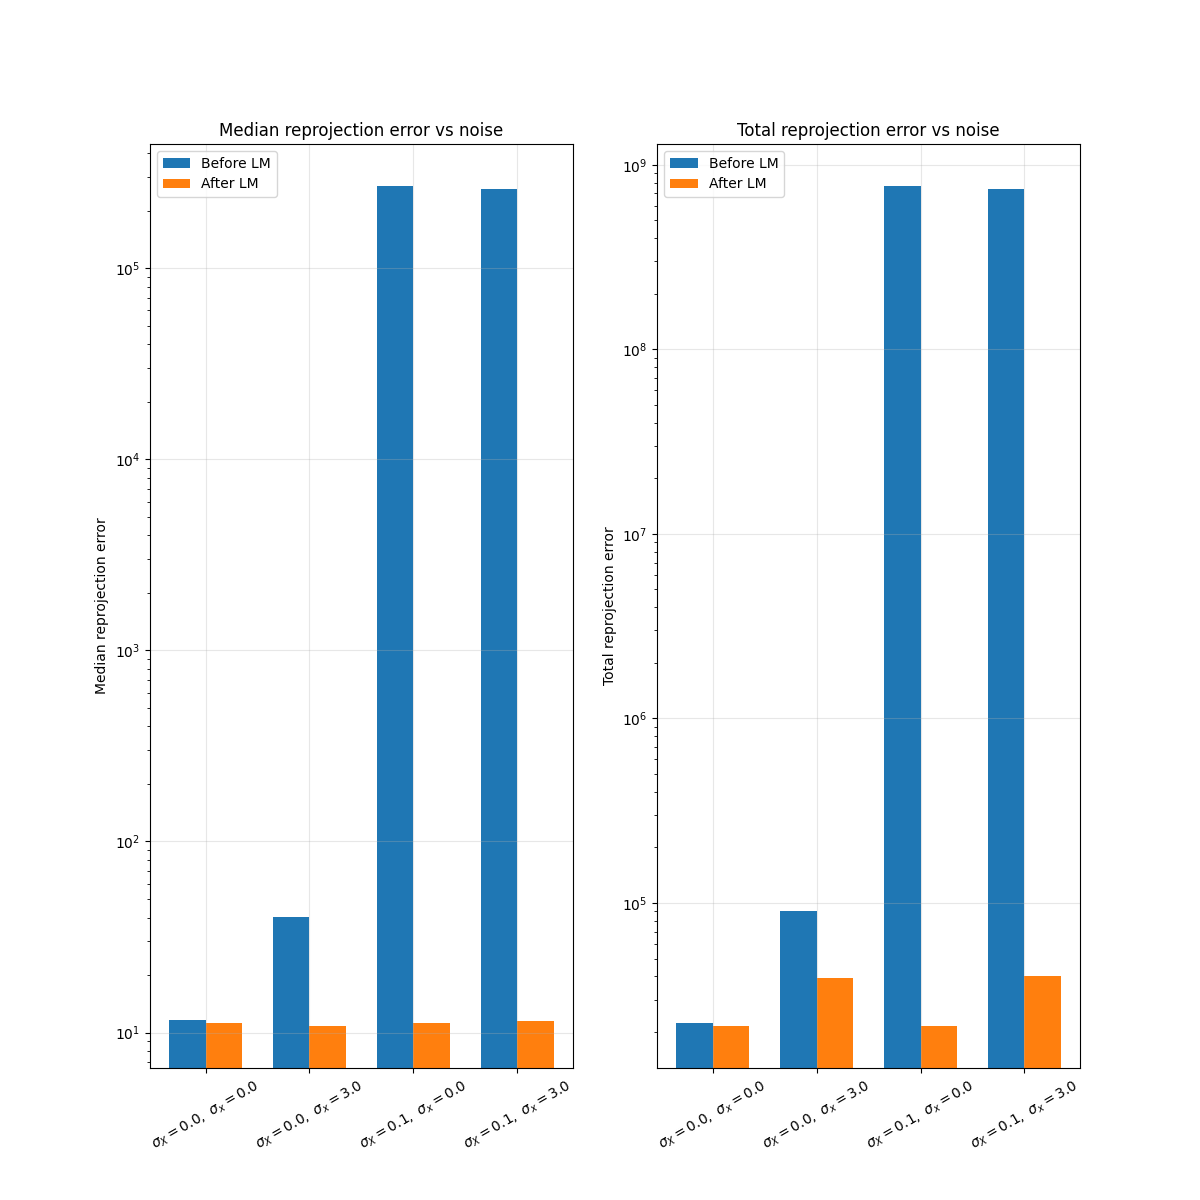

In [27]:
labels = [f"$\\sigma_X={r['sigma_X']},\\ \\sigma_x={r['sigma_x']}$" for r in results]

median_before = [r["median_before"] for r in results]
median_after  = [r["median_after"]  for r in results]

total_before = [r["total_before"] for r in results]
total_after  = [r["total_after"]  for r in results]

x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

# ---- Median reprojection error ----
axes[0].bar(x - width/2, median_before, width,
            color='tab:blue', label="Before LM")
axes[0].bar(x + width/2, median_after, width,
            color='tab:orange', label="After LM")
axes[0].set_yscale('log')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=30)
axes[0].set_ylabel("Median reprojection error")
axes[0].set_title("Median reprojection error vs noise")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---- Total reprojection error ----
axes[1].bar(x - width/2, total_before, width,
            color='tab:blue', label="Before LM")
axes[1].bar(x + width/2, total_after, width,
            color='tab:orange', label="After LM")
axes[1].set_yscale('log')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=30)
axes[1].set_ylabel("Total reprojection error")
axes[1].set_title("Total reprojection error vs noise")
axes[1].legend()
axes[1].grid(alpha=0.3)

